In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

#from crossmatch import xmatch
import astropy as apy
from astropy import units as units
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

from astroML.stats import binned_statistic_2d

% matplotlib inline

## Setup data paths

In [2]:
DATA_DIR = "data/"
HLC_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "HLC*.fits")))
NSC_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "stripe82*.txt")))
GAL_FILES = 'data/Galfast-Stripe82.txt'
print("\nRegistered following NSC files: ")
for pth in NSC_FILES:
    print("    "+pth)
print("\nRegistered following HLC files: ")
for pth in HLC_FILES:
    print("    "+pth)
print("\nRegistered following GALFAST files: ")
print("    "+GAL_FILES)


Registered following NSC files: 
    data/stripe82_315_ra_45_-1_3_dec_0.txt
    data/stripe82_315_ra_45_0_dec_1_3.txt

Registered following HLC files: 
    data/HLC.RA_00_to_01.fits
    data/HLC.RA_01_to_02.fits
    data/HLC.RA_02_to_03.fits
    data/HLC.RA_03_to_04.fits
    data/HLC.RA_20_to_21.fits
    data/HLC.RA_21_to_22.fits
    data/HLC.RA_22_to_23.fits
    data/HLC.RA_23_to_24.fits

Registered following GALFAST files: 
    data/Galfast-Stripe82.txt


In [3]:
galdat = np.loadtxt('data/Galfast-Stripe82.txt')
galfast = Table(rows=galdat, names=("ra", "dec", "glon", "glat", "pmra", "pmdec", "px", "rv", "Teff", "FeH",
                                    "log(g)", "u", "g", "r", "i", "z", "y"))

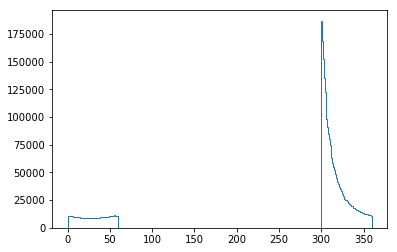

In [17]:
a = plt.hist(galfast["ra"], histtype="step", bins=360)

In [7]:
nscdat_part = []
for pth in NSC_FILES:
    nscdat_part.append(Table.read(pth, format="ascii"))
nscdat = apy.table.vstack(nscdat_part)
nsc = Table(nscdat)

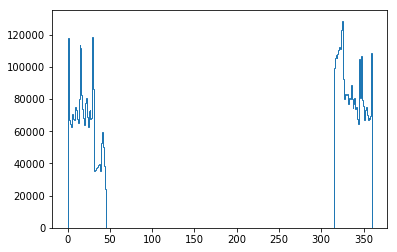

In [16]:
a = plt.hist(nsc["ra"], histtype="step", bins=360)

In [9]:
hlcdat_part = []
for pth in HLC_FILES:
    fitsfile = fits.open(pth)
    tmptable = Table(fitsfile[1].data)
    hlcdat_part.append(tmptable)
hlc = apy.table.vstack(hlcdat_part)

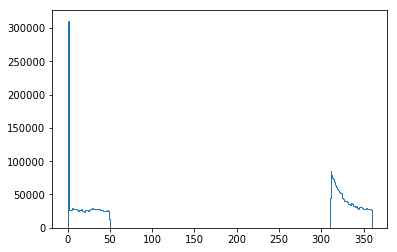

In [10]:
a = plt.hist(hlc["RA_MEAN_CLIP"], histtype="step", bins=360)

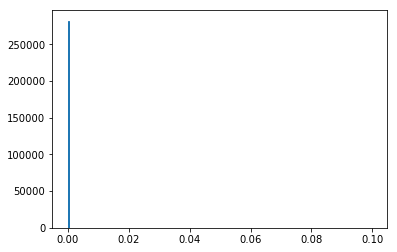

In [6]:
a = plt.hist(hlc[hlc["RA_MEAN_CLIP"]<0.1]["RA_MEAN_CLIP"], histtype="step", bins=360)

## Get the matched data, this is about the same size as full cats

This is just about pointless considering what my input data looks like.

In [18]:
gal2nsc = Table.read(DATA_DIR+"matched/galfast2nsc_cat", format="ascii")

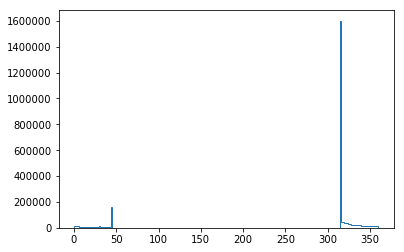

In [19]:
a = plt.hist(gal2nsc["ra"], histtype="step", bins=360)

In [13]:
hlc2nsc = Table.read(DATA_DIR+"matched/hlc2nsc_cat", format="ascii")

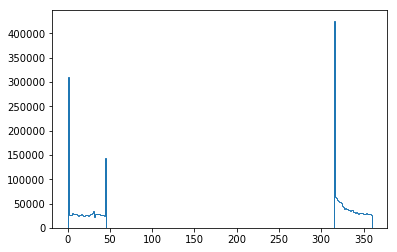

In [14]:
a = plt.hist(hlc2nsc["ra"], histtype="step", bins=360)

In [ ]:
xmatchdat = []
with open(DATA_DIR+"matched/xmatch_hlc2nsc", "r") as xmatch:
    for line in xmatch.readlines():
        xmatchdat.append(np.fromstring(line, sep=" ",dtype=np.float64))
idx, angsep, dist = xmatchdat[0], xmatchdat[1], xmatchdat[2]

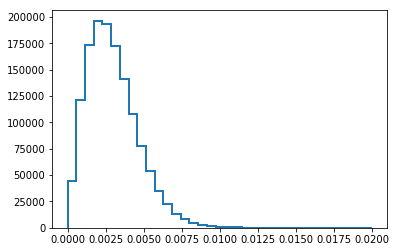

In [58]:
a = plt.hist(angsep[angsep<0.000277778], histtype='step', lw=2 , bins=35)

## Setup matched catalog paths

In [14]:
DATA_DIR = "data/matched1/"
HLC2NSC_FILES = DATA_DIR+"hlc2nsc_cat"
GAI2NSC_FILES = DATA_DIR+"gaia2nsc_cat"
GAI2HLC_FILES = DATA_DIR+"gaia2hlc_cat"

HLC2NSC_XMATCH = DATA_DIR+"xmatch_hlc2nsc"
GAI2NSC_XMATCH = DATA_DIR+"xmatch_gaia2nsc"
GAI2HLC_XMATCH = DATA_DIR+"xmatch_gaia2hlc"

print("\nRegistered following HLC2NSC files: ")
print("    "+HLC2NSC_FILES)
print("    "+HLC2NSC_XMATCH)
print("\nRegistered following GAI2NSC files: ")
print("    "+GAI2NSC_FILES)
print("    "+GAI2NSC_XMATCH)
print("\nRegistered following GAI2HLC files: ")
print("    "+GAI2HLC_FILES)
print("    "+GAI2HLC_XMATCH)


Registered following HLC2NSC files: 
    data/matched1/hlc2nsc_cat
    data/matched1/xmatch_hlc2nsc

Registered following GAI2NSC files: 
    data/matched1/gaia2nsc_cat
    data/matched1/xmatch_gaia2nsc

Registered following GAI2HLC files: 
    data/matched1/gaia2hlc_cat
    data/matched1/xmatch_gaia2hlc


### Make sure separations and matches look ok

In [20]:
def get_xmatch_info(path):
    xmatchdat = []
    with open(path, "r") as xmatch:
        for line in xmatch.readlines():
            xmatchdat.append(np.fromstring(line, sep=" ",dtype=np.float64))
    idx, angsep, dist = xmatchdat[0], xmatchdat[1], xmatchdat[2]
    return idx, angsep, dist

### First for HLC2NSC matches

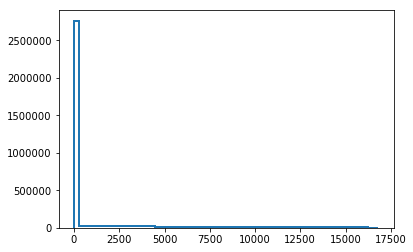

In [16]:
hlc2nsc_id, hlc2nsc_angsep, hlc2nsc_dist = get_xmatch_info(HLC2NSC_XMATCH)
a = plt.hist(hlc2nsc_angsep, histtype='step', lw=2 , bins=60)

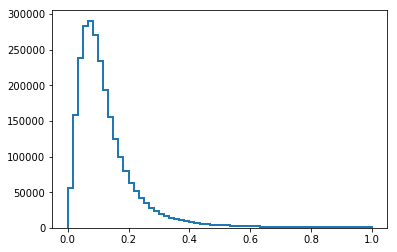

In [17]:
a = plt.hist(hlc2nsc_angsep[hlc2nsc_angsep<1], histtype='step', lw=2 , bins=60)

### Then Gaia2NSC matches

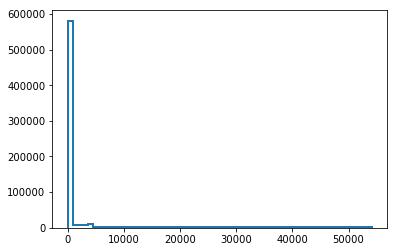

In [18]:
gai2nsc_id, gai2nsc_angsep, gai2nsc_dist = get_xmatch_info(GAI2NSC_XMATCH)
a = plt.hist(gai2nsc_angsep, histtype='step', lw=2 , bins=60)

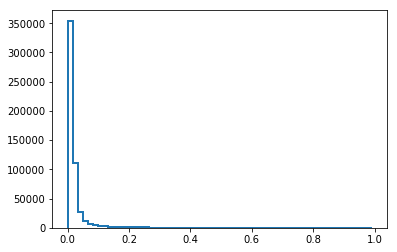

In [19]:
a = plt.hist(gai2nsc_angsep[gai2nsc_angsep<1], histtype='step', lw=2 , bins=60)

### Finally for Gaia to HLC matches

In [ ]:
gai2hlc_id, gai2hlc_angsep, gai2hlc_dist = get_xmatch_info(GAI2HLC_XMATCH)
a = plt.hist(gai2hlc_angsep, histtype='step', lw=2 , bins=60)